# Demo

Here we demonstrate how to use $\texttt{Rave}$ to:
 * Simulate a simple image of a debris disk
 * Recover its face-on surface brightness as a function of radius ("surface brightness profile", or "radial profile")
 * Recover its scale height as a function of radius ("height profile")

If you haven't installed $\texttt{Rave}$ yet, please refer to the [installation instructions](https://yinuohan.github.io/rave/) before returning to this demo. 

Before doing anything, let's first import $\texttt{Rave}$ and a few other useful packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

os.chdir('/Users/yinuo/Documents/GitHub/rave')
from rave import *

%matplotlib inline
plt.rc('font', family='Serif', size=12)
plt.rcParams["figure.figsize"] = (12, 7)

$\texttt{Rave}$ caches data files on your machine to speed up calculations. If you've used $\texttt{Rave}$ before, you may have already cached some data files in a directory on your machine. If not, you may want to specify a directory for $\texttt{Rave}$ to cache these data files. In either case, before running anything, it's a good idea to change to the directory where you chached $\texttt{Rave}$ files or would like to cache them:

In [2]:
# Change the line below to where you want to cache your data files
cache_directory = '/Users/yinuo/Desktop/Model/New Model' 
os.chdir(cache_directory)

## Simulating an observation

Now we are ready to simulate an observation.

For this demo, let's use a "smooth" test case which has a radial profile and height profile that are both smooth. 

### Defining the disk

We create the disk by summing up small a series of narrow annuli, each of which has uniform face-on surface brightness and is one pixel wide. The structure of the disk is then defined by 3 things:
* The boundaries defining the annuli (or in equivalent terminology, "rings"), or radial bins
* The surface brightness, or weights, of each annulus
* The scale height of each annulus

Here, let's make up a disk that extends in radius up to 100 pixels. 

In [3]:
# Boundaries of the annuli used to make the disk (in pixels)
r_bounds_make = np.arange(0, 100.1, 1)

# The centre of each annulus, or radial bin
r = (r_bounds_make[1: ] + r_bounds_make[ :-1]) / 2

# A Gaussian scaled to reach a max of 1
def g(r, mu, sigma):
    return np.exp(-((r-mu)/sigma)**2)

# The surface brightness of all annuli
weights_make = 4.2 * (2*g(r, 0, 30) + 1*g(r, 50, 20) + 0.5*g(r, 90, 50))
# The factor of 4.2 is here to ensure the mean S/N per beam is 10 once noise is added later

# The scale height of all annuli (in pixels)
heights_make = 5*g(r, 1, 25) + 6*g(r, 40, 25) + 10*g(r, 100, 50)

Let's plot these profiles. To make it super clear exactly what we are dealing with, lets work in pixels for now. Later on we will have the option to present these results in more physically meaningful units for real observations. 

Text(0, 0.5, 'Height (pixels)')

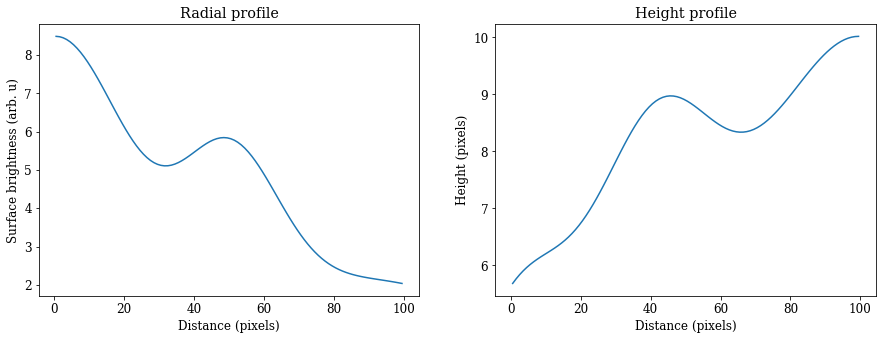

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r, weights_make)
ax[0].set_title('Radial profile')
ax[0].set_xlabel('Distance (pixels)')
ax[0].set_ylabel('Surface brightness (arb. u)')

ax[1].plot(r, heights_make)
ax[1].set_title('Height profile')
ax[1].set_xlabel('Distance (pixels)')
ax[1].set_ylabel('Height (pixels)')

The next step is to specify how the disk imaged is simulated. The main things are:
* Inclination of the disk
* The point-spread function (PSF), or in equivalent terminology, "beam", of the observation
* Dimensions of the image (the simulated image is always square)
* How many sampel points to simulate per pixel for the Monte Carlo, if the image was viewed face-on. 

In [5]:
# Inclination
inclination_make = 90

# Kernel
beam_fwhm = 5
kernel = make_kernel(29, beam_fwhm/2.355)

# Dimensions of the simulated image (in pixels)
dim = 200
# If the image to be fitted to is larger than this, consider down-sampling to dim = 200 to speed up the code

# How accurate the simulation needs to be
n_points_per_pixel = 200
# Recommend using 200 for most cases

Text(0, 0.5, 'Pixels')

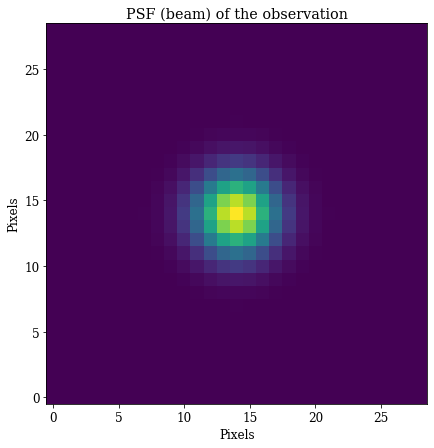

In [6]:
plt.imshow(kernel, origin='lower')
plt.title('PSF (beam) of the observation')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

### Simulating the disk

Now we are ready to simulate an image of the disk. We do this by creating a MakeImage object which does all the work of making up the disk image:

In [7]:
image = MakeImage(r_bounds_make, 
                  weights_make, 
                  heights_make, 
                  inclination_make, 
                  dim, 
                  n_points_per_pixel, 
                  kernel, 
                  scale=1, # au per pixel. Not so important when simulating a fake image
                  rapid=False, # use True if you have already cached narrow annuli
                  add_before_convolve=True # always use True
                 )

Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6


The numbers printed out tracks the progress of the code by telling you how many annuli are left to be made. 

We can easily plot the disk image using the $\texttt{plot}$ method:

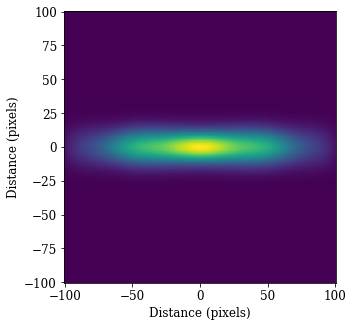

In [8]:
image.plot(unit='pixel')

### Adding noise

To add noise, we must first specify the mean signal-to-noise ("S/N" or "SNR") per beam of the disk image. To know how much noise to add to each pixel, we must also specify the region of the image within which there is actual flux. This should exclude regions where there is only background noise. 

In [9]:
# S/N per beam
snr_per_beam = 10

# Distance from the disk's major axis within which there is disk flux (in pixels)
y_max = 30

Now add noise:

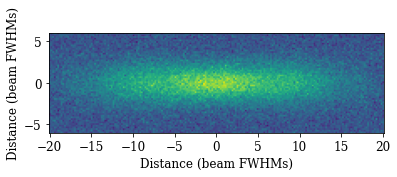

In [10]:
# Specify region with flux
image.flux_region(y_max, mode='specify')

# Add noise
image.noise_by_snr(snr_per_beam, beam_fwhm, mode='add')

# Plot again
image.plot(unit='beam')
# Now that we have recorded the beam_fwhm, we can use it as the unit

## The fitting begins



### Improve the S/N of the input image

To improve the S/N of the image before doing any fitting we can do 2 things:
* Sum the image with the 180-degree rotated image. For the purpose of runnning $\texttt{Rave}$, this is essentially the same thing as summing the left and right halves of the disk. The code assumes that the disk is azimuthally symmetric (i.e. circularly symmetric, and so any variation is only radial) which implies that the left and eight halves should be identical. If you are worried whether if this is not the case for your data, you can skip this step and fit the left and right halves independently. 
* Exclude any region that does contains only background noise by setting it to 0.

The following methods do these tricks:


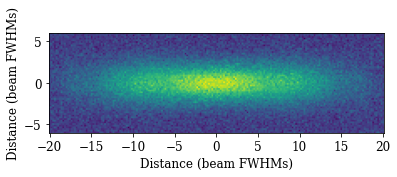

In [11]:
# Sum the image with its 180-degree rotated image and divide by 2. 
image.add_flip()
# This automatically does the same thing to the kernel. 

# Set the region outside y_max to 0. 
image.flux_region(y_max, mode='cut')

# Plot the image again
image.plot(unit='beam')

### Fitting the radial profile

Now let the fitting begin! Let's first fit the face-on surface brightness profile, a.k.a. the radial profile. 

We begin by creating a Radial Profile Fitter object which contains things to do with radial profiles.

In [12]:
radial = RadialProfile(image)

# The Image object and Radial Profile Fitter object are linked
print(radial.image == image,
      image.radial == radial
     )

True True


The next step is to load the rapid annuli used to perform the fitting. During the fitting process, the algorithm generates images of annuli many many times. This can be sped up by pre-generating lots of narrow annuli and summing them up to create bigger annuli. If you have already cached narrow annuli which the right properties, the code will use these. Otherwise the code will make up new ones, which might take a little while. 

In [13]:
radial.get_rapid_annuli(r_outer=image.cx, 
                            # image.cx is the maximum distance from the central star along the x-axis with flux
                        dr=0.1, 
                            # How narrow the narrow annuli are. Here they are 0.1 pixels wide
                        height=10, 
                            # How tall the narrow annuli are
                            # This doesn't affect radial profile fitting, but you have the freedom to choose it anyway
                            # Setting it to a height that is used later in height fitting may speed things up later
                        inclination=90,
                            # The inclination of the narrow annuli
                            # Again, this doesn't affect radial profile fitting.
                            # Setting it to the inclination used later in height fitting may speed things up later
                       )



----- Radial annuli -----
    Found stored rings 200_200_10_90_200_0.1


Now do the fit! The most important thing to choose is nrings. We recommend experimenting with different values and examining the quality of the fitted profile. 

In [14]:
radial.fit(nrings=7, 
               # The most important thing to check. 
               # To be sure the fit is physical|, try a few different values. 
           n_iterations=100, 
               # How many sets of random annuli to generate and fit with
               # Recommend using 100 in most cases
           extra_noise=image.noise_per_pixel
               # If this is not 0, the code repeats the fitting on the best-fit model
               # For this second set of fits, the code adds a different set of random noise to the image
               # The magnitude of this noise is equal to extra_noise
               # Unless there is a reason not to do so, extra_noise should be image.noise_per_pixel
          )


----- Radial Fit -----
    Found stored rbounds
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6
n 0 n 1 n 2 n 3 n 4 n 5 n 6 n 7 n 8 n 9 n 10 n 11 n 12 n 13 n 14 n 15 n 16 n 17 n 18 n 19 n 20 n 21 n 22 n 23 n 24 n 25 n 26 n 27 n 28 n 29 n 30 n 31 n 32 n 33 n 34 n 35 n 36 n 37 n 38 n 39 n 40 n 41 n 42 n 43 n 44 n 45 n 46 n 47 n 48 n 49 n 50 n 51 n 52 n 53 n 54 n 55 n 56 n 57 n 58 n 59 n 60 n 61 n 62 n 63 n 64 n 65 n 66 n 67 n 68 n 69 n 70

The code lets you track the progress of the fitting by printing which iteration the fitting is up to. Fits to the model which are done as a second round of fitting are labelled by the prefix 'n'. 

Now let's plot the fitted result:

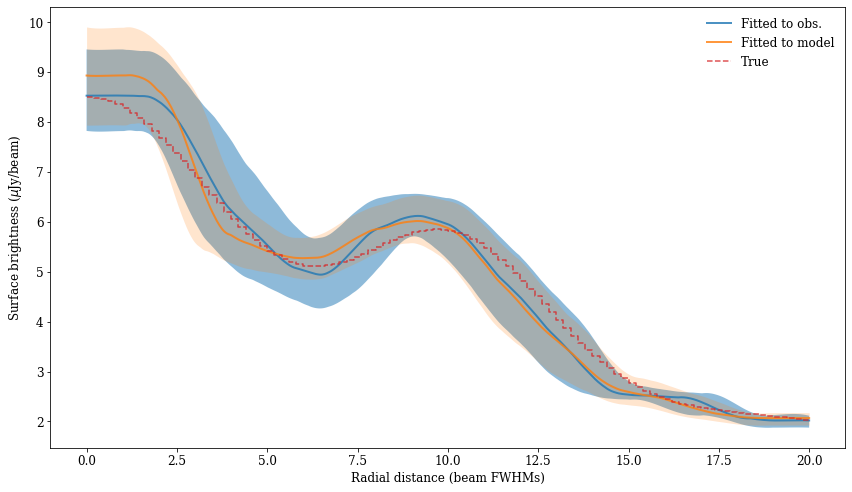

In [15]:
radial.plot(smooth=101, # How much to smooth the fitted curve by
            use_au='beam' # Unit of the plot's x-axis
           )

Also plot a few individual fits to see what the code is doing:

Text(0, 0.5, 'Surface brightness')

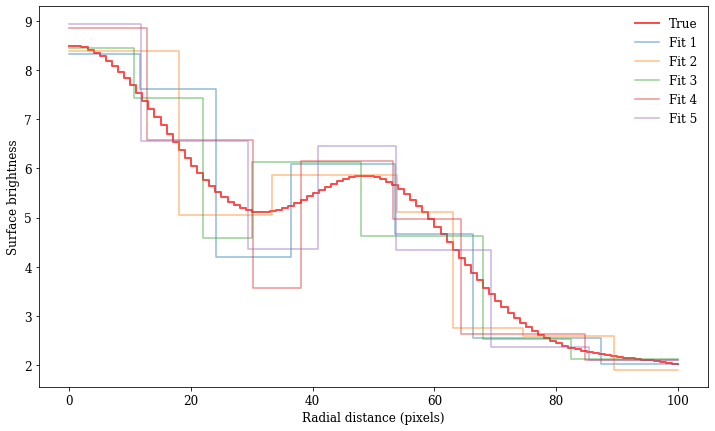

In [16]:
X = radial.R_BOUNDS
Y = radial.MTXRATIOS

plt.figure()
pltstep(image.r_bounds_make, image.weights_make, 'r', alpha=0.7, label='True', lw=2)
for i in range(5):
    pltstep(X[i], Y['right'][i], alpha=0.5, label=f'Fit {i+1}')

plt.legend(frameon=False)
plt.xlabel('Radial distance (pixels)')
plt.ylabel('Surface brightness')

So the code is basically...

Things to watch for when choosing nrings:
* nrings should be smaller than half the number of beams across the disk's major axis. 
* If the final fitted profile is strongly oscilltory, this is a sign that nrings might be too big.
* If the final fitted profile abruptly becomes 0 at multiple locations, this is a sign that nrings might be too big. 
* In the two cases above, check image.plot_compare to see if it might be fitting to the noise (see later section). 

In general, the bigger nrings is, the higher the resolution of the fitted profile (if the noise is small), but the more susceptible the fit is to noise. Moving to smaller values of nrings makes the fit more robust against noise, but may decrease the resolution. 

Now we can create a face-on model image of the simulated observation:

Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6


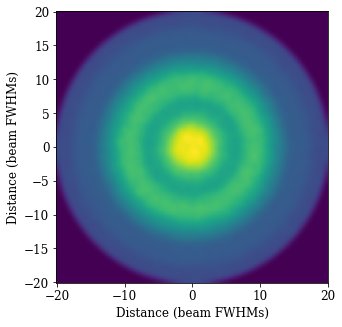

In [17]:
image.make_model(inclination=0, heights=10, n_points_per_pixel=200, rapid=True, use_kernel=True)

# Give the model a beam_fwhm so that it can plot in units of 'beam'
image.model.beam_fwhm = beam_fwhm
image.model.plot(unit='beam')

We have just flipped the disk around to a face-on perspective! This is cool since we didn't have to assume anything to do with the functional form defining the structure of the disk, except that the disk is azimuthally symmetric. This is certainly a lot easier than sending a spacecraft into distant outer space to see what a star and its debris disk would look like from a different angle. 

### Inclination constraints

When fitting the scale height of the disk later, we need to make an assumption about the inclination of the disk. When there are no other lines of evidence that constrain the inclination of the disk, we can try and put a lower bound on the inclination first before proceeding to fit the height. 

$\texttt{Rave}$ has a handy way to model perfectly flat disks (height = 0 everywhere) and plot their midplane fluxes if the disk was viewed at different inclinations. The modelled disks use the radial profile that we just fitted. 

Since flux is most concentrated in the midplane when the disk is perfectly flat, we should expect the midplane flux of a flat version of our disk to always be greater than the observed midplane flux at all locations. If this condition is violated, the inlination must be too low to be physical. 

Let's plot a flat disk that take on the radial profile that we just fitted at several different inclinations. 

Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6
Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6
Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6
Making image
99 98 97 96 95 94 93 92 91 90 89 88 

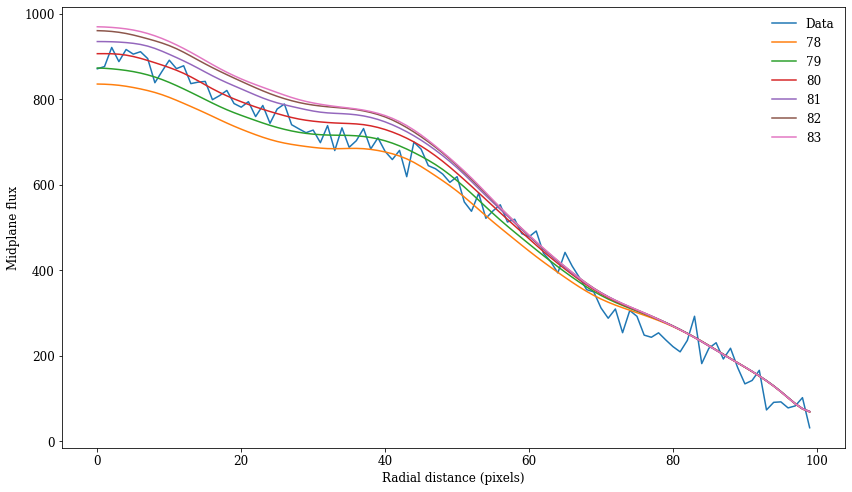

In [18]:
image.estimate_inclination(cut_height=15,
                               # This is distance away from the major axis which defines the "midplane region" (in pixels)
                               # It needs to fully ecompass the "centrol hole" of the disk (if any)
                               # cut_height >= (radius of centrol hole) * sin(90deg - inc)
                               # Can conservatively estimate radius of the centrol hole as max radius with flux
                           inc_range=[78, 83], 
                               # Range of inclination to estimate over
                           di=1, 
                               # Spacing of inclinations
                          )

The model curves above show that at any inclination below 80 degrees, even a flat disk cannot concentrate enough flux near the midplane. We can therefore estimate the lower bound of the inclination to be at least 80 degrees. 

### Height profile

Now that we have some idea about roughly what range inclination values can take, let's fit the height. 

Ordinarily, when we don't know what the precise inclination is, we would repeat the height fitting for multiple inclination assumptions so that we can clearly see how the fitted height varies with inclination. When future observations can better constrain the inclination, we can come back and choose the right fit. 

Here we fit the height assuming that the inclination is 90 degrees (equal to the true inclination). The fitting process assuming other inclinations is basically the same, so we leave it as an exercise for you to try fitting with different inclination assumptions. 

Similar to the radial profile fitting procedure, we first create a Height Profile fitter object and then load the narrow annuli to help the algorithm quick make up model images. 

This time, we need narrow annuli at a range of different heights, because the algorithm needs to change the heights around in the model until finding the right heights that reproduce the observation. The rapid annuli method of summing up very narrow annuli only works when the height is fixed. Here, rather than generating a completely new annuli every time the height varies, the code makes up narrow annuli only at a few select heights and interpolates between these heights to obtain models at all other heights in between. 

In [19]:
# Create Height Profile Fitter object
height = HeightProfile(image)
print(image.height == height,
     height.image == image
     )

# Load narrow annuli
inclination_fit = 90
height.get_rapid_annuli(r_outer=image.cx, 
                            # See radial profile fitting 
                        dr=0.1, 
                            # See radial profile fitting
                        hrange=[0, 20], 
                            # The plausible range that contains the true height everywhere along the disk
                            # We can draw a line profile in the vertical direction and estimate the FWHM
                            # Then subtract the kernel's vertical FWHM to estimate the height
                            # Then expand the estimate to a relatively large range, e.g. [0, 2 * height guess]
                        dh=2, 
                            # The spacing between heights of narrow annuli that are sampled within hrange
                        inclination=inclination_fit
                            # Inclination assumption
                       )


True True

----- Height annuli -----
    Found stored rings 200_200_0_90_100_0.1
    Found stored rings 200_200_2_90_100_0.1
    Found stored rings 200_200_4_90_100_0.1
    Found stored rings 200_200_6_90_100_0.1
    Found stored rings 200_200_8_90_100_0.1
    Found stored rings 200_200_10_90_200_0.1
    Found stored rings 200_200_12_90_100_0.1
    Found stored rings 200_200_14_90_100_0.1
    Found stored rings 200_200_16_90_100_0.1
    Found stored rings 200_200_18_90_100_0.1
    Found stored rings 200_200_20_90_100_0.1


Here, I have already cached narrow annuli with the required properties. If you don't have these narrow annuli chached, this step may take a while to run (usually on the order of minutes or even 10s of minutes).

Now we are ready run the height fitter!

In [20]:
height.fit(nrings=5, 
               # Number of annuli to use
               # Height fitting will carry on inaccuracies in the best fit radial profile
               # This usually works better if it is slightly smaller than nrings for radial profile fitting
           flux_range=[0, 100], 
               # The range of distances from the star that has substantial flux (in pixels)
               # Regions beyond this range are assumed to have a height of starting_height
               # The height can't be fitted robustly where there is too little flux (effectively undefined height)
               # We can inspect the radial profile fit and exclude regions where the surface brightness is 0 within uncertainties
           cut_height=10, 
               # See cut_height in image.estimate_inclination
               # Here the inclination is 90 degrees so there is no theoretical limit on the cut_height to use
               # We can set it to be the same as starting_height for best sensitivity
           starting_height=5, 
               # A very rough estimate of what the mean height is across the disk (in pixels)
               # This does not have to be accurate. 
               # Make sure it is within hrange. 
           n_iterations=100, 
               # See radial profile fitting 
           extra_noise=image.noise_per_pixel, 
               # See radial profile fitting 
           remove_default=True
               # If remove_default is True, the code makes a model of the region outside flux_range
               # It then subtracts this image from the input image before fitting the height
               # This is to minimise flux from low-flux regions interfering with the flux from flux_range
          )


----- Height Fit -----
    Found stored rbounds
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6
n 0 n 1 n 2 n 3 n 4 n 5 n 6 n 7 n 8 n 9 n 10 n 11 n 12 n 13 n 14 n 15 n 16 n 17 n 18 n 19 n 20 n 21 n 22 n 23 n 24 n 25 n 26 n 27 n 28 n 29 n 30 n 31 n 32 n 33 n 34 n 35 n 36 n 37 n 38 n 39 n 40 n 41 n 42 n 43 n 44 n 45 n 46 n 47 n 48 n 49 n 50 n 51 n 52 n 53 n 54 n 55 n 56 n 57 n 58 n 59 n 60 n 61 n 62 n 63 n 64 n 65 n 66 n 67 n 68 n 69 n 70

The meaning of the printed numbers is the same as before for radial profile fitting. 

Now let's plot the fitted scale height!

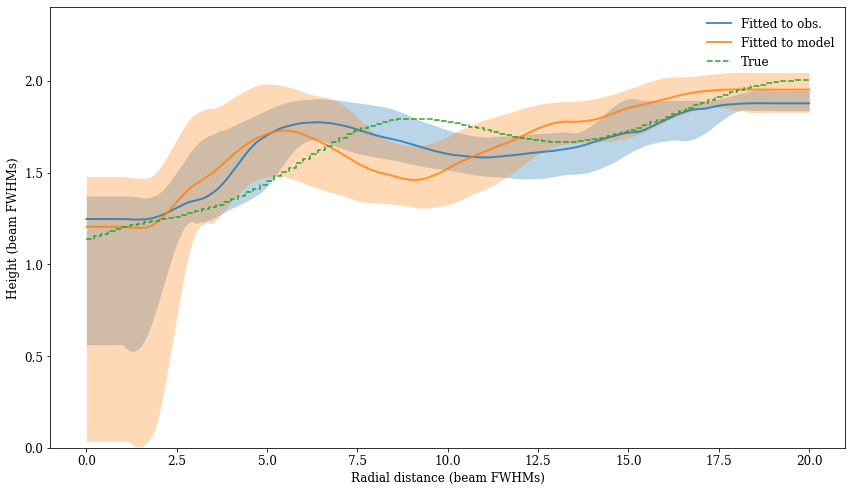

In [21]:
height.plot(smooth=101, 
            use_au='beam'
           )

## The final model

A model of the disk is specified by
* The fitted radial profile
* The fitted height profile under one or more inclination assumptions

Now that we have fitted both, we can generate model images of the disk viewed from at any inclination we like. Let's make one that is perfectly edge-on. 

In [22]:
image.make_model(inclination=inclination_fit, 
                     # Use the inclination assumed for height fitting
                 heights=None, 
                     # Heights = None means use the fitted height
                 n_points_per_pixel=200, 
                     # Same as before
                 rapid=True, 
                     # Make model by summing up narrow annuli
                 use_kernel=True, 
                     # Convolve with PSF/beam
                 default_height=height.starting_height
                     # The final model needs to include the low-flux regions
                     # There assumed height, or default_height, was set as height.starting_height
                )

Making image
99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 Time taken: 6


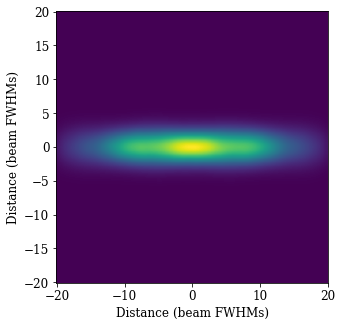

In [23]:
image.model.beam_fwhm = beam_fwhm
image.model.plot(unit='beam')

### Quality of the fit

How do we know that we have a good fit to the data? The algorithm is really fitting to 2 observables:
* Full 1D flux, obtained by integrating all the flux vertically, to get flux as a function of x-distance
* Midplane flux, obtained by integrating all the flux close to the midplane/major axis vertically, to get flux near the midplane as a function of x-distance


So one thing to check is that these two observables are reasonably reproduced. 

We can do this with the handly plot_compare method:

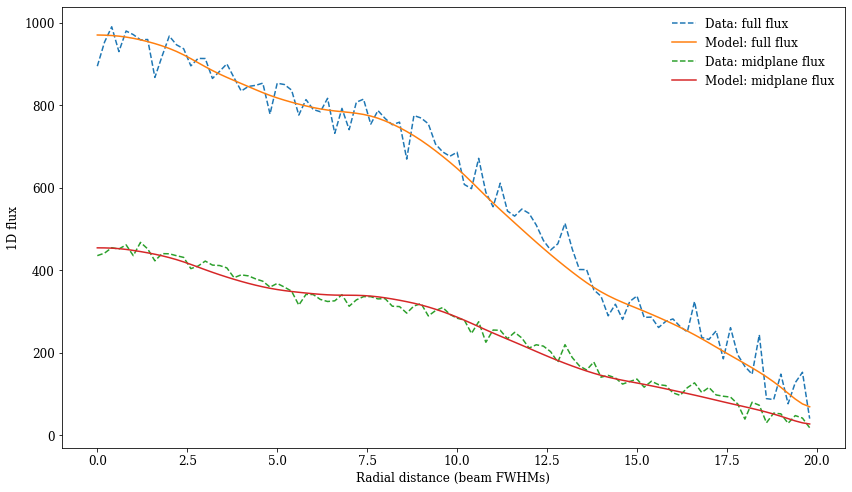

In [24]:
image.plot_compare(cut_height=5, unit='beam')
# Note that this must be run after image.make_model, with the inclination matching that used for height fitting

It seems like the two osbervables are reproduced well. The full flux of the model is slightly higher towards small distances. This is because the method may output negative fitted surface brightnesses at some locations. To achieve a physical model, the code then floors everything to 0, which may result in a higher flux particularly at regions with larger uncertainties in the fitted radial profile. 

Another thing to check is that the full residual image doesn't have any significant flux:

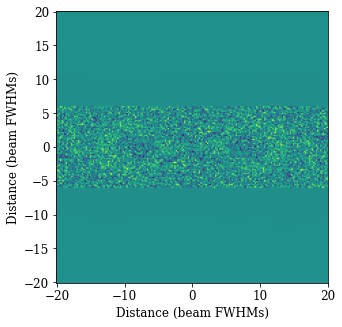

In [25]:
dif = image.image - image.model.image
background_noise = np.std(dif[70:130, 0:20])
dif /= background_noise
dif = np.clip(dif, -3, 3)
dif_image = Image(dif, kernel=None, scale=1)
dif_image.beam_fwhm=beam_fwhm

dif_image.plot(unit='beam')

Overall this is a reasonable fit to the data. 

Now we have a better understanding of the structure of our disk!